# 1D toy regression problem with sinusoidal data

This tutorial introduces how to use `pytagi` to train a simple model that is able to learn a simple sinusoidal data. Using this example, we see how to create an MLP, train the model and use it to get some predictions on an unseen data. Run it now in [Google Colab](https://colab.research.google.com/drive/1lgWDebPds9fw1wKxaOF8j_vJcK9UsKFX?usp=sharing).

## Data Generation

We define 1D toy data from a sinusoidal function. We first generate the training and testing data given $Y=-(x+0.5)\sin(3\pi x)+ V, V \sim \mathcal{N}(0,0.1^2)$.

In [1]:
# Uncomment the following lines to install the required packages if not already installed
#!pip install pytagi
#!pip install numpy
#!pip install tqdm

import numpy as np

np.random.seed(0)

def generate_data(n_samples, noise_std):
    x = np.random.uniform(-1, 1, n_samples)
    y = -(x + 0.5) * np.sin(3 * np.pi * x) + np.random.normal(0, noise_std, n_samples)
    return x, y

n_train_samples = 500 # Try modifying the # of training samples to see how it affects to the epistemic uncertainty
n_test_samples = 1000
noise_std = 0.1

x_train, y_train = generate_data(n_train_samples, noise_std)
x_test, y_test = generate_data(n_test_samples, noise_std)

We can visualize the raw 1D data using `matplotlib`.

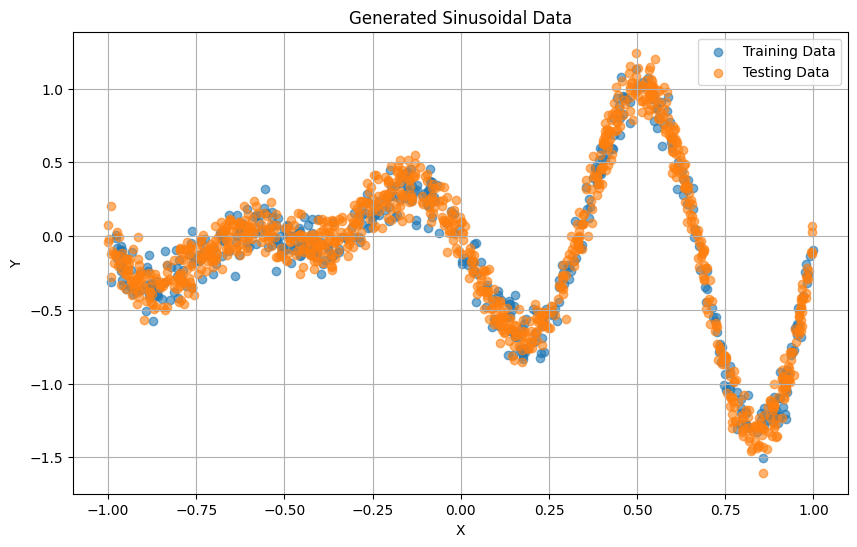

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, label='Training Data', alpha=0.6)
plt.scatter(x_test, y_test, label='Testing Data', alpha=0.6)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Generated Sinusoidal Data')
plt.legend()
plt.grid(True)
plt.show()

## Data Normalization

Before training a model, it's a common practice to normalize the data. Normalization helps to bring features to a similar scale, which can improve the performance and training speed of TAGI.

In [3]:
def standardize(data, mean, std):
  return (data - mean) / std

def unstandardize(data, mean, std):
  return data * std + mean

In [4]:
# Manual normalization using training data statistics
mean_x = np.mean(x_train)
std_x = np.std(x_train)
x_train_scaled_manual = standardize(x_train, mean_x, std_x)
x_test_scaled_manual = standardize(x_test, mean_x, std_x)

mean_y = np.mean(y_train)
std_y = np.std(y_train)
y_train_scaled_manual = standardize(y_train, mean_y, std_y)
y_test_scaled_manual = standardize(y_test, mean_y, std_y)

## Model Building

`pytagi` currently supports only Sequential model definition. In this case we use Linear layers and ReLU activation functions.

In [5]:
from pytagi.nn import Linear, OutputUpdater, ReLU, Sequential

net = Sequential(
  Linear(1, 50),
  ReLU(),
  Linear(50, 50),
  ReLU(),
  Linear(50, 50),
  ReLU(),
  Linear(50, 1),
)


In [6]:
num_epochs = 10
batch_size = 10
sigma_v    = noise_std # Observation noise, corresponding to the aleatoric uncertainty

out_updater = OutputUpdater(net.device)
var_y = np.full((batch_size,), sigma_v**2, dtype=np.float32)

## Model Training

The training loop is simple and consist in 4 main parts:
- we do the forward pass when calling the network `_, _ = net(x_batch)`.
- using the `out_updater.update` function, we update the output layer.
- we then use `net.backward()` and `net.step()` to propagate all the updated information to the parameters.
- finally we unstandardize the predictions and using the metric class, we get the MSE and log likelihood of the predictions.

In this simple tutorial we manually generate our batched data, but in general, `pytagi` is concived to be simple and flexible so we can rely on other libraries for the whole data processing.

In [7]:
from tqdm import tqdm
import pytagi.metric as metric

mses = []
pbar = tqdm(range(num_epochs), desc="Training Progress")
for epoch in pbar:
    # Create batches of the scaled training data
    num_batches = len(x_train_scaled_manual) // batch_size
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        x_batch = x_train_scaled_manual[start_idx:end_idx].reshape(-1, 1).astype(np.float32)
        y_batch = y_train_scaled_manual[start_idx:end_idx]

        # Feed forward
        m_pred, _ = net(x_batch)

        # Update output layer
        out_updater.update(
            output_states=net.output_z_buffer,
            mu_obs=y_batch,
            var_obs=var_y,
            delta_states=net.input_delta_z_buffer,
        )

        # Feed backward
        net.backward()
        net.step()

        # Training metric
        pred = unstandardize(
            m_pred, mean_y, std_y
        )
        obs = unstandardize(y_batch, mean_y, std_y) # Unstandardize the observed batch for metric calculation
        mse = metric.mse(pred, obs)
        mses.append(mse)

    # Progress bar
    pbar.set_description(
        f"Epoch {epoch + 1}/{num_epochs}| mse: {sum(mses)/len(mses):>7.2f}",
        refresh=True,
    )

Epoch 10/10| mse:    0.11: 100%|██████████| 10/10 [00:00<00:00, 19.10it/s]


## Model Testing

Similar to the training, we go through all the data and get the predictions of the model and compute the corresponding metrics.

In [8]:
mean_preds = []
var_preds = []
y_test_batches = []

num_test_batches = len(x_test_scaled_manual) // batch_size
for i in range(num_test_batches):
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    x_batch = x_test_scaled_manual[start_idx:end_idx].reshape(-1, 1).astype(np.float32)
    y_batch = y_test_scaled_manual[start_idx:end_idx].reshape(-1, 1).astype(np.float32)

    # Prediction
    m_pred_batch, v_pred_batch = net(x_batch)

    # Collect predictions and original y_test values
    mean_preds.extend(m_pred_batch.flatten().tolist())
    var_preds.extend(v_pred_batch.flatten().tolist())
    y_test_batches.extend(y_batch.flatten().tolist())

mean_preds = np.array(mean_preds)
var_preds = np.array(var_preds)
y_test_batches = np.array(y_test_batches)

# Add observation noise variance to the variance predictions
epistemic_uncertainty = var_preds
aleatoric_uncertainty = sigma_v**2
var_preds = epistemic_uncertainty + aleatoric_uncertainty
std_preds = var_preds ** 0.5

# Unstandardize the predictions and original test data for metric calculation
mean_preds_unscaled = unstandardize(mean_preds, mean_y, std_y)
std_preds_unscaled = std_preds * std_y # Unstandardize std by multiplying with original std_y
y_test_unscaled = unstandardize(y_test_batches, mean_y, std_y)


# Compute log-likelihood and MSE
mse = metric.mse(mean_preds_unscaled, y_test_unscaled)
log_lik = metric.log_likelihood(
  prediction=mean_preds_unscaled, observation=y_test_unscaled, std=std_preds_unscaled
)

print(f"Test MSE: {mse:.4f}")
print(f"Test Log-Likelihood: {log_lik:.4f}")

Test MSE: 0.0183
Test Log-Likelihood: -0.4487


## Prediction Visualization

Finally, we can visualize the predictions made by the model and distinguis the 2 uncertainties; (1) the epistemic uncertainty, corresponig to the model and (2) the aleatoric uncertainty, corresponding to the fixed noise on the data that we previously set.

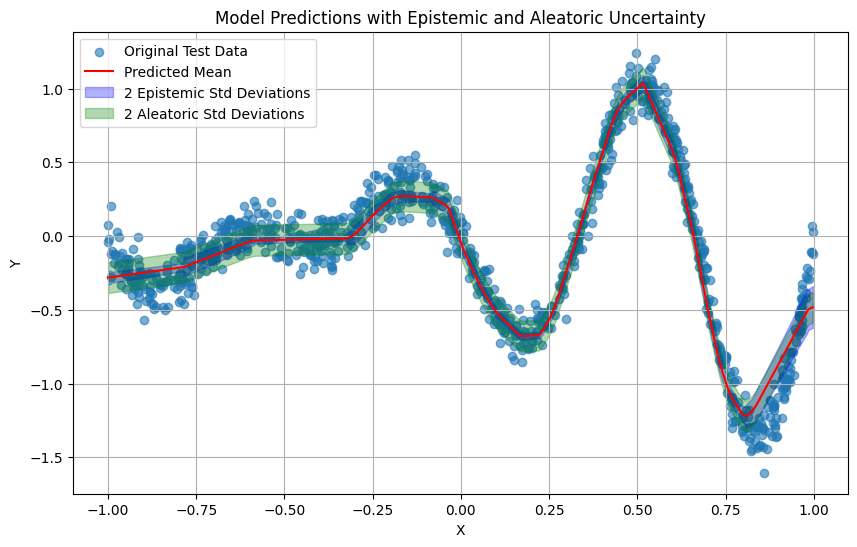

In [9]:
# Sort the test data for plotting
sorted_indices = np.argsort(x_test_scaled_manual.flatten())
x_test_sorted = x_test_scaled_manual[sorted_indices]
y_test_sorted = y_test_scaled_manual[sorted_indices]
mean_preds_sorted = mean_preds[sorted_indices]
epistemic_var_preds_sorted = var_preds[sorted_indices] - sigma_v**2 # Extract epistemic variance
aleatoric_var_preds_sorted = np.full_like(epistemic_var_preds_sorted, sigma_v**2) # Aleatoric variance is constant

# Ensure epistemic variance is non-negative
epistemic_var_preds_sorted[epistemic_var_preds_sorted < 0] = 0


epistemic_std_preds_sorted = epistemic_var_preds_sorted ** 0.5
aleatoric_std_preds_sorted = aleatoric_var_preds_sorted ** 0.5


# Unstandardize sorted data for plotting
x_test_sorted_unscaled = unstandardize(x_test_sorted, mean_x, std_x)
y_test_sorted_unscaled = unstandardize(y_test_sorted, mean_y, std_y)
mean_preds_sorted_unscaled = unstandardize(mean_preds_sorted, mean_y, std_y)
epistemic_std_preds_sorted_unscaled = epistemic_std_preds_sorted * std_y
aleatoric_std_preds_sorted_unscaled = aleatoric_std_preds_sorted * std_y


plt.figure(figsize=(10, 6))
plt.scatter(x_test_sorted_unscaled, y_test_sorted_unscaled, label='Original Test Data', alpha=0.6)
plt.plot(x_test_sorted_unscaled, mean_preds_sorted_unscaled, color='red', label='Predicted Mean')

# Plot epistemic uncertainty band
plt.fill_between(
    x_test_sorted_unscaled,
    mean_preds_sorted_unscaled - 2 * epistemic_std_preds_sorted_unscaled,
    mean_preds_sorted_unscaled + 2 * epistemic_std_preds_sorted_unscaled,
    color='blue',
    alpha=0.3,
    label='2 Epistemic Std Deviations',
)

# Plot aleatoric uncertainty band
plt.fill_between(
    x_test_sorted_unscaled,
    mean_preds_sorted_unscaled - 2 * aleatoric_std_preds_sorted_unscaled,
    mean_preds_sorted_unscaled + 2 * aleatoric_std_preds_sorted_unscaled,
    color='green',
    alpha=0.3,
    label='2 Aleatoric Std Deviations',
)


plt.xlabel('X')
plt.ylabel('Y')
plt.title('Model Predictions with Epistemic and Aleatoric Uncertainty')
plt.legend()
plt.grid(True)
plt.show()